# Neural Network Hands-On Tutorial Part 2

## MNIST Classification Task

In [15]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading the MNIST Dataset

`torchvision` provides many built-in datasets, which are common benchmarks and can be used for learning purposes and drafting your own neural network implementations.

Run the next cell to download the MNIST dataset and store it to the `./data` folder.


In [94]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

### Looking at the Dataset

The MNIST train dataset contains 60,000 pairs of data in the shape of (image, label).

Each image is a grayscale image cropped to 28*28 pixels, with a centered handwritten digit.

_Note_: the test dataset contains 10,000 images with the same shape as the train data.

In [95]:
print(len(train_dataset))
print(train_dataset[0])

60000
(<PIL.Image.Image image mode=L size=28x28 at 0x1470FA1D0>, 5)


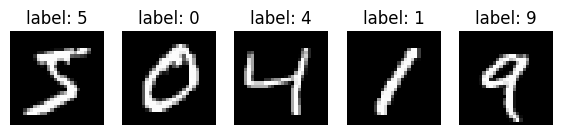

In [96]:
idx = 0  # Change the index to see different images

# Show some images
fig, axes = plt.subplots(1, 5, figsize=(7, 2.5))
for i in range(5):
    axes[i].imshow(train_dataset[i+idx][0], cmap='gray')
    axes[i].set_title(f"label: {train_dataset[i+idx][1]}")
    axes[i].axis('off')

Currently, the images are `PIL` images and the amplitudes range from 0 to 255.

In [97]:
img = train_dataset[0][0]
print(np.max(img), np.min(img), np.shape(img))

255 0 (28, 28)


### Data Preprocessing

In order to train a neural network with the dataset, the train dataset needs to be pre-processed. In `PyTorch` and `torchvision`, this can be achieved by `torchvision.transforms`, which includes many common image processing methods.

Note that the images in the MNIST dataset are already _centered_ and _cropped to the same shape_. (For your own dataset, remember to perform these steps.)

We only need to perform two steps:

1. Convert the PIL images with amplitude $[0,255]$ to PyTorch Tensors in $[0,1]$, with `transforms.ToTensor()`
2. Normalize the images to $\mu=0.5$ and $\sigma=0.5$, with `transforms.Normalize()`

Multiple transformations can be chained by using `transforms.Compose`

In [98]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    # transforms.Normalize((0.5,), (0.5,))  # Normalize image to mean 0.5 and std 0.5
])

Let's define the train and test dataset again, with the proper transformations

In [99]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

We can load mini-batches of data from the dataset using `DataLoader`.

Setting `shuffle=True` allows the batches to be sampled in a random order across different episodes. 

Why do we need it? $\rightarrow$ Prevents converging into local optima and overfitting.



In [100]:
batchsize = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

We can now look at one batch of data sampled from the `DataLoader`

The input data shape would be: [batch_size, channel, height, width]. Here channel=1 because we are using grayscale images. 

In [56]:
images, labels = next(iter(train_loader))
print("Input batch shape: ", images.shape)
print("Output batch shape: ", labels.shape)

Input batch shape:  torch.Size([64, 1, 28, 28])
Output batch shape:  torch.Size([64])


### Define the neural network structure

For the MNIST task, it is sufficient to use a small, fully-connected neural network.

In [61]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, hidden_size=128):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [74]:
model = SimpleNN().to(device)
print(model) # Look at the model architecture

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Define the loss function

Here we are dealing with a classification problem with 10 classes (digits from 0 to 9), which loss function should we use?

**Cross-entropy Loss**

For one data pair $(x,y)$, the cross-entropy loss is calculated

$$
l_\text{Cross-Entropy}(y,y') = - \sum_{i=1}^{C} \log \frac{\exp{y_i}}{\sum_{c=1}^{C} \exp{(y_{c})}} y'_{i},
$$

Here 
- $\{1, \dots, C=10 \}$ class indices. 
- $y'$ is a one-hot vector, i.e. $y'_{i}=1$ if the ground truth label is class $i$. 
- $y$ is the output predicted by the neural network.



- Note 1: The first part $\exp{y_i}/\sum_c\exp{y_c}$ is a `Softmax` activation, mapping the unbounded outputs to probabilities between $[0,1]$.
- Note 2: For the batched input, the loss is commonly averaged over the batches.

In [75]:
criterion = nn.CrossEntropyLoss()

### Define an optimizer

We can choose from the common optimizers, see [`torch.optim` documentation](https://pytorch.org/docs/stable/optim.html):
- Stochastic gradient descent ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)): `optim.SGD`
- [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam): `optim.Adam`

In [76]:
# Feel free to change the optimizer and its hyperparameters
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

### Start Training

In [77]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs): # Loop through the dataset multiple epochs
        for i, (images, labels) in enumerate(train_loader): # Loop through batches in the train loader
            images, labels = images.to(device), labels.to(device) # Move data to device (GPU if available)
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss

            optimizer.zero_grad() # Prepare for backward pass
            loss.backward() # Backward pass
            optimizer.step() # Update model parameters

            if (i+1) % 400 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [78]:
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Step [400/938], Loss: 0.2695
Epoch [1/10], Step [800/938], Loss: 0.1714
Epoch [2/10], Step [400/938], Loss: 0.1585
Epoch [2/10], Step [800/938], Loss: 0.0839
Epoch [3/10], Step [400/938], Loss: 0.0802
Epoch [3/10], Step [800/938], Loss: 0.1878
Epoch [4/10], Step [400/938], Loss: 0.0210
Epoch [4/10], Step [800/938], Loss: 0.0512
Epoch [5/10], Step [400/938], Loss: 0.0237
Epoch [5/10], Step [800/938], Loss: 0.1229
Epoch [6/10], Step [400/938], Loss: 0.0809
Epoch [6/10], Step [800/938], Loss: 0.0892
Epoch [7/10], Step [400/938], Loss: 0.0264
Epoch [7/10], Step [800/938], Loss: 0.0085
Epoch [8/10], Step [400/938], Loss: 0.0167
Epoch [8/10], Step [800/938], Loss: 0.0160
Epoch [9/10], Step [400/938], Loss: 0.0594
Epoch [9/10], Step [800/938], Loss: 0.0239
Epoch [10/10], Step [400/938], Loss: 0.0266
Epoch [10/10], Step [800/938], Loss: 0.0220


### Evaluating the model

In [79]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.67%


### Visualize the model predictions

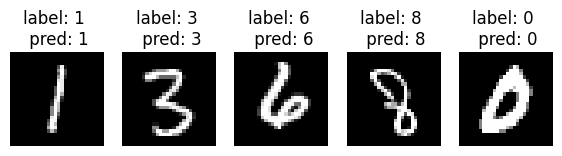

In [108]:
# Redefine a loader to allow for visualization of random test images
random_test_loader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

images, labels = next(iter(random_test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predictions = torch.max(outputs, 1)

# Show some images
fig, axes = plt.subplots(1, 5, figsize=(7, 2.5))
for i in range(5):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"label: {labels[i]} \n pred: {predictions[i]}")
    axes[i].axis('off')

### What's next

Change the hyperparameters of the network, training process, and observe what will happen

### Bonus

Try a different network structure, which one would you use?